In [50]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import re

import plotly.figure_factory as ff
import matplotlib.pyplot as plt

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [2]:
# With the 500 Cities summary table and updated FIPS codes, it is now easier to merge the two databases.

In [3]:
# With the food access program in mind, I want to first show that food access correlates with health.

In [4]:
# There are a few different metrics of low food access in the table, so I want to see how each relates to health outcomes.

In [34]:
conn = sqlite3.connect('challenge.db')
cursor = conn.cursor()

cursor.execute("PRAGMA table_info(five_hundred_cities_summary)")
table_info_500c = cursor.fetchall()

exclude_columns = ['FIPS', 'StateAbbr', 'PlaceName', 'Total_Population2010', 'Access2_CrudePrev_weighted_average']  
health_columns_500c = [col[1] for col in table_info_500c if col[1] not in exclude_columns]

query = f"""
    SELECT a.PCT_LACCESS_POP10, {', '.join(health_columns_500c)}
    FROM access AS a
    JOIN five_hundred_cities_summary AS b ON a.FIPS = b.FIPS
"""

df1 = pd.read_sql(query, conn)

correlations = df1.corr()
df1_correlations = correlations['PCT_LACCESS_POP10'].sort_values(ascending=False)
print("Correlations with PCT_LACCESS_POP10:")
print(df1_correlations)

Correlations with PCT_LACCESS_POP10:
PCT_LACCESS_POP10                      1.000000
OBESITY_CrudePrev_weighted_avg         0.297891
ARTHRITIS_CrudePrev_weighted_avg       0.240483
CSMOKING_CrudePrev_weighted_avg        0.239154
COPD_CrudePrev_weighted_avg            0.220493
LPA_CrudePrev_weighted_avg             0.204829
BPHIGH_CrudePrev_weighted_avg          0.199940
CHD_CrudePrev_weighted_avg             0.183802
MHLTH_CrudePrev_weighted_avg           0.177442
PHLTH_CrudePrev_weighted_avg           0.159344
TEETHLOST_CrudePrev_weighted_avg       0.157810
BPMED_CrudePrev_weighted_avg           0.152962
STROKE_CrudePrev_weighted_avg          0.141127
HIGHCHOL_CrudePrev_weighted_avg        0.130376
ACCESS2_CrudePrev_weighted_avg         0.119588
DIABETES_CrudePrev_weighted_avg        0.112440
CASTHMA_CrudePrev_weighted_avg         0.107973
KIDNEY_CrudePrev_weighted_avg          0.102551
CANCER_CrudePrev_weighted_avg          0.099892
CHECKUP_CrudePrev_weighted_avg         0.074842
SLE

In [6]:
# Here, I found positive, but somewhat weak correlations between health outcomes and the LACCESS_POP10 variable.

In [35]:
conn = sqlite3.connect('challenge.db')
cursor = conn.cursor()

cursor.execute("PRAGMA table_info(five_hundred_cities_summary)")
table_info_500c = cursor.fetchall()

exclude_columns = ['FIPS', 'StateAbbr', 'PlaceName', 'Total_Population2010', 'Access2_CrudePrev_weighted_average']  
health_columns_500c = [col[1] for col in table_info_500c if col[1] not in exclude_columns]

query = f"""
    SELECT a.PCT_LACCESS_LOWI10, {', '.join(health_columns_500c)}
    FROM access AS a
    JOIN five_hundred_cities_summary AS b ON a.FIPS = b.FIPS
"""

df2 = pd.read_sql(query, conn)

correlations = df2.corr()
df2_correlations = correlations['PCT_LACCESS_LOWI10'].sort_values(ascending=False)
print("Correlations with PCT_LACCESS_LOWI10:")
print(df2_correlations)

Correlations with PCT_LACCESS_LOWI10:
PCT_LACCESS_LOWI10                     1.000000
ACCESS2_CrudePrev_weighted_avg         0.419859
OBESITY_CrudePrev_weighted_avg         0.397110
LPA_CrudePrev_weighted_avg             0.381471
BPHIGH_CrudePrev_weighted_avg          0.328694
DIABETES_CrudePrev_weighted_avg        0.308708
MHLTH_CrudePrev_weighted_avg           0.306270
PHLTH_CrudePrev_weighted_avg           0.301721
CHD_CrudePrev_weighted_avg             0.300098
KIDNEY_CrudePrev_weighted_avg          0.290495
STROKE_CrudePrev_weighted_avg          0.288441
CSMOKING_CrudePrev_weighted_avg        0.281751
COPD_CrudePrev_weighted_avg            0.276172
TEETHLOST_CrudePrev_weighted_avg       0.268984
HIGHCHOL_CrudePrev_weighted_avg        0.186011
ARTHRITIS_CrudePrev_weighted_avg       0.185326
BPMED_CrudePrev_weighted_avg           0.166325
SLEEP_CrudePrev_weighted_avg           0.080097
CHECKUP_CrudePrev_weighted_avg         0.038462
CASTHMA_CrudePrev_weighted_avg         0.036883
CA

In [8]:
# The correlations, between health outcomes and the PCT_LACCESS_LOWI10 variable, were a bit stronger.

In [9]:
# I still want to find a stronger correlation before I make my visualization, as I want it to indisputably show that
# low access to food is correlated with poor health outcomes. I am going to use the obesity metric from the "health" table,
# as it will include more rural data than exists in the 500 Cities database.

In [61]:
conn = sqlite3.connect('challenge.db')
cursor = conn.cursor()

cursor.execute("PRAGMA table_info(five_hundred_cities_summary)")
table_info_500c = cursor.fetchall()

exclude_columns = ['FIPS', 'StateAbbr', 'PlaceName', 'Total_Population2010', 'Access2_CrudePrev_weighted_average']  
health_columns_500c = [col[1] for col in table_info_500c if col[1] not in exclude_columns]

query = f"""
    SELECT a.PCT_LACCESS_SNAP15, {', '.join(health_columns_500c)}
    FROM access AS a
    JOIN five_hundred_cities_summary AS b ON a.FIPS = b.FIPS
"""

df3 = pd.read_sql(query, conn)

correlations = df3.corr()
df3_correlations = correlations['PCT_LACCESS_SNAP15'].sort_values(ascending=False)
print("Correlations with PCT_LACCESS_SNAP15:")
print(df3_correlations)

Correlations with PCT_LACCESS_SNAP15:
PCT_LACCESS_SNAP15                     1.000000
OBESITY_CrudePrev_weighted_avg         0.519407
BPHIGH_CrudePrev_weighted_avg          0.453884
LPA_CrudePrev_weighted_avg             0.448185
DIABETES_CrudePrev_weighted_avg        0.446743
STROKE_CrudePrev_weighted_avg          0.433447
KIDNEY_CrudePrev_weighted_avg          0.415999
PHLTH_CrudePrev_weighted_avg           0.412319
CHD_CrudePrev_weighted_avg             0.402858
ACCESS2_CrudePrev_weighted_avg         0.400973
COPD_CrudePrev_weighted_avg            0.396361
CSMOKING_CrudePrev_weighted_avg        0.393036
MHLTH_CrudePrev_weighted_avg           0.366704
TEETHLOST_CrudePrev_weighted_avg       0.362084
ARTHRITIS_CrudePrev_weighted_avg       0.327294
BPMED_CrudePrev_weighted_avg           0.293288
HIGHCHOL_CrudePrev_weighted_avg        0.268189
SLEEP_CrudePrev_weighted_avg           0.238855
CASTHMA_CrudePrev_weighted_avg         0.200808
CHECKUP_CrudePrev_weighted_avg         0.172158
CA

In [11]:
# The LACCESS_SNAP15 variable is even more strongly correlated with health outcomes, with obesity being the strongest correlation.

In [12]:
# This leads me to believe that targeting a food access program at individuals recieving SNAP benefits would have the dual
# advantage of helping those most at risk of issues like obesity and hypertension and targeting a population that already
# recieves some benefits and may thus be more receptive to joining the pilot program.

In [13]:
# One thing that I want to acknowledge is that, up to this point, I have been focusing exclusively on the health variables from 
# the 500 Cities database, as provided by the CDC, as opposed to those in the FDA Food Atlas database. This is because the 500 Cities 
# database is far more extensive in its level of detail on health: it includes datapoints for a number of diseases and behaviors,
# while the USDA database only includes data on obesity and diabetes. With that said, the 500 Cities database only represents 326 of the 
# 3143 counties in the U.S., and an especially urban subset of those counties at that. This gave me pause initially, but after further
# research into the counties that the CDC database includes, only 68 of them are actually classified as urban, with many counties
# that ostensibly exist within city limits still being totally rural, like the northern chunk of Abilene, TX for example.

# This is to say that the CDC database, which I am using for health outcomes, is not as representative as the USDA database,
# but for the purposes of this project I believe that its level of detail justifies some of its shortcomings. 

In [14]:
# Out of curiosity, I still want to see if the USDA health metrics correlate as tightly with food access as the CDC health metrics do.

In [37]:
conn = sqlite3.connect('challenge.db')
cursor = conn.cursor()

query = f"""
    SELECT a.PCT_LACCESS_SNAP15, b.PCT_DIABETES_ADULTS13, b.PCT_OBESE_ADULTS13
    FROM access AS a
    JOIN health AS b ON a.FIPS = b.FIPS
"""

df4 = pd.read_sql(query, conn)

correlations = df4.corr()
df4_correlations = correlations['PCT_LACCESS_SNAP15'].sort_values(ascending=False)
print("Correlations with PCT_LACCESS_SNAP15:")
print(df4_correlations)

Correlations with PCT_LACCESS_SNAP15:
PCT_LACCESS_SNAP15       1.000000
PCT_OBESE_ADULTS13       0.160679
PCT_DIABETES_ADULTS13    0.136373
Name: PCT_LACCESS_SNAP15, dtype: float64


In [16]:
# These correlations were fairly weak in comparison, so I am going to proceed with the 500 Cities health data instead for my 
# first visualization.

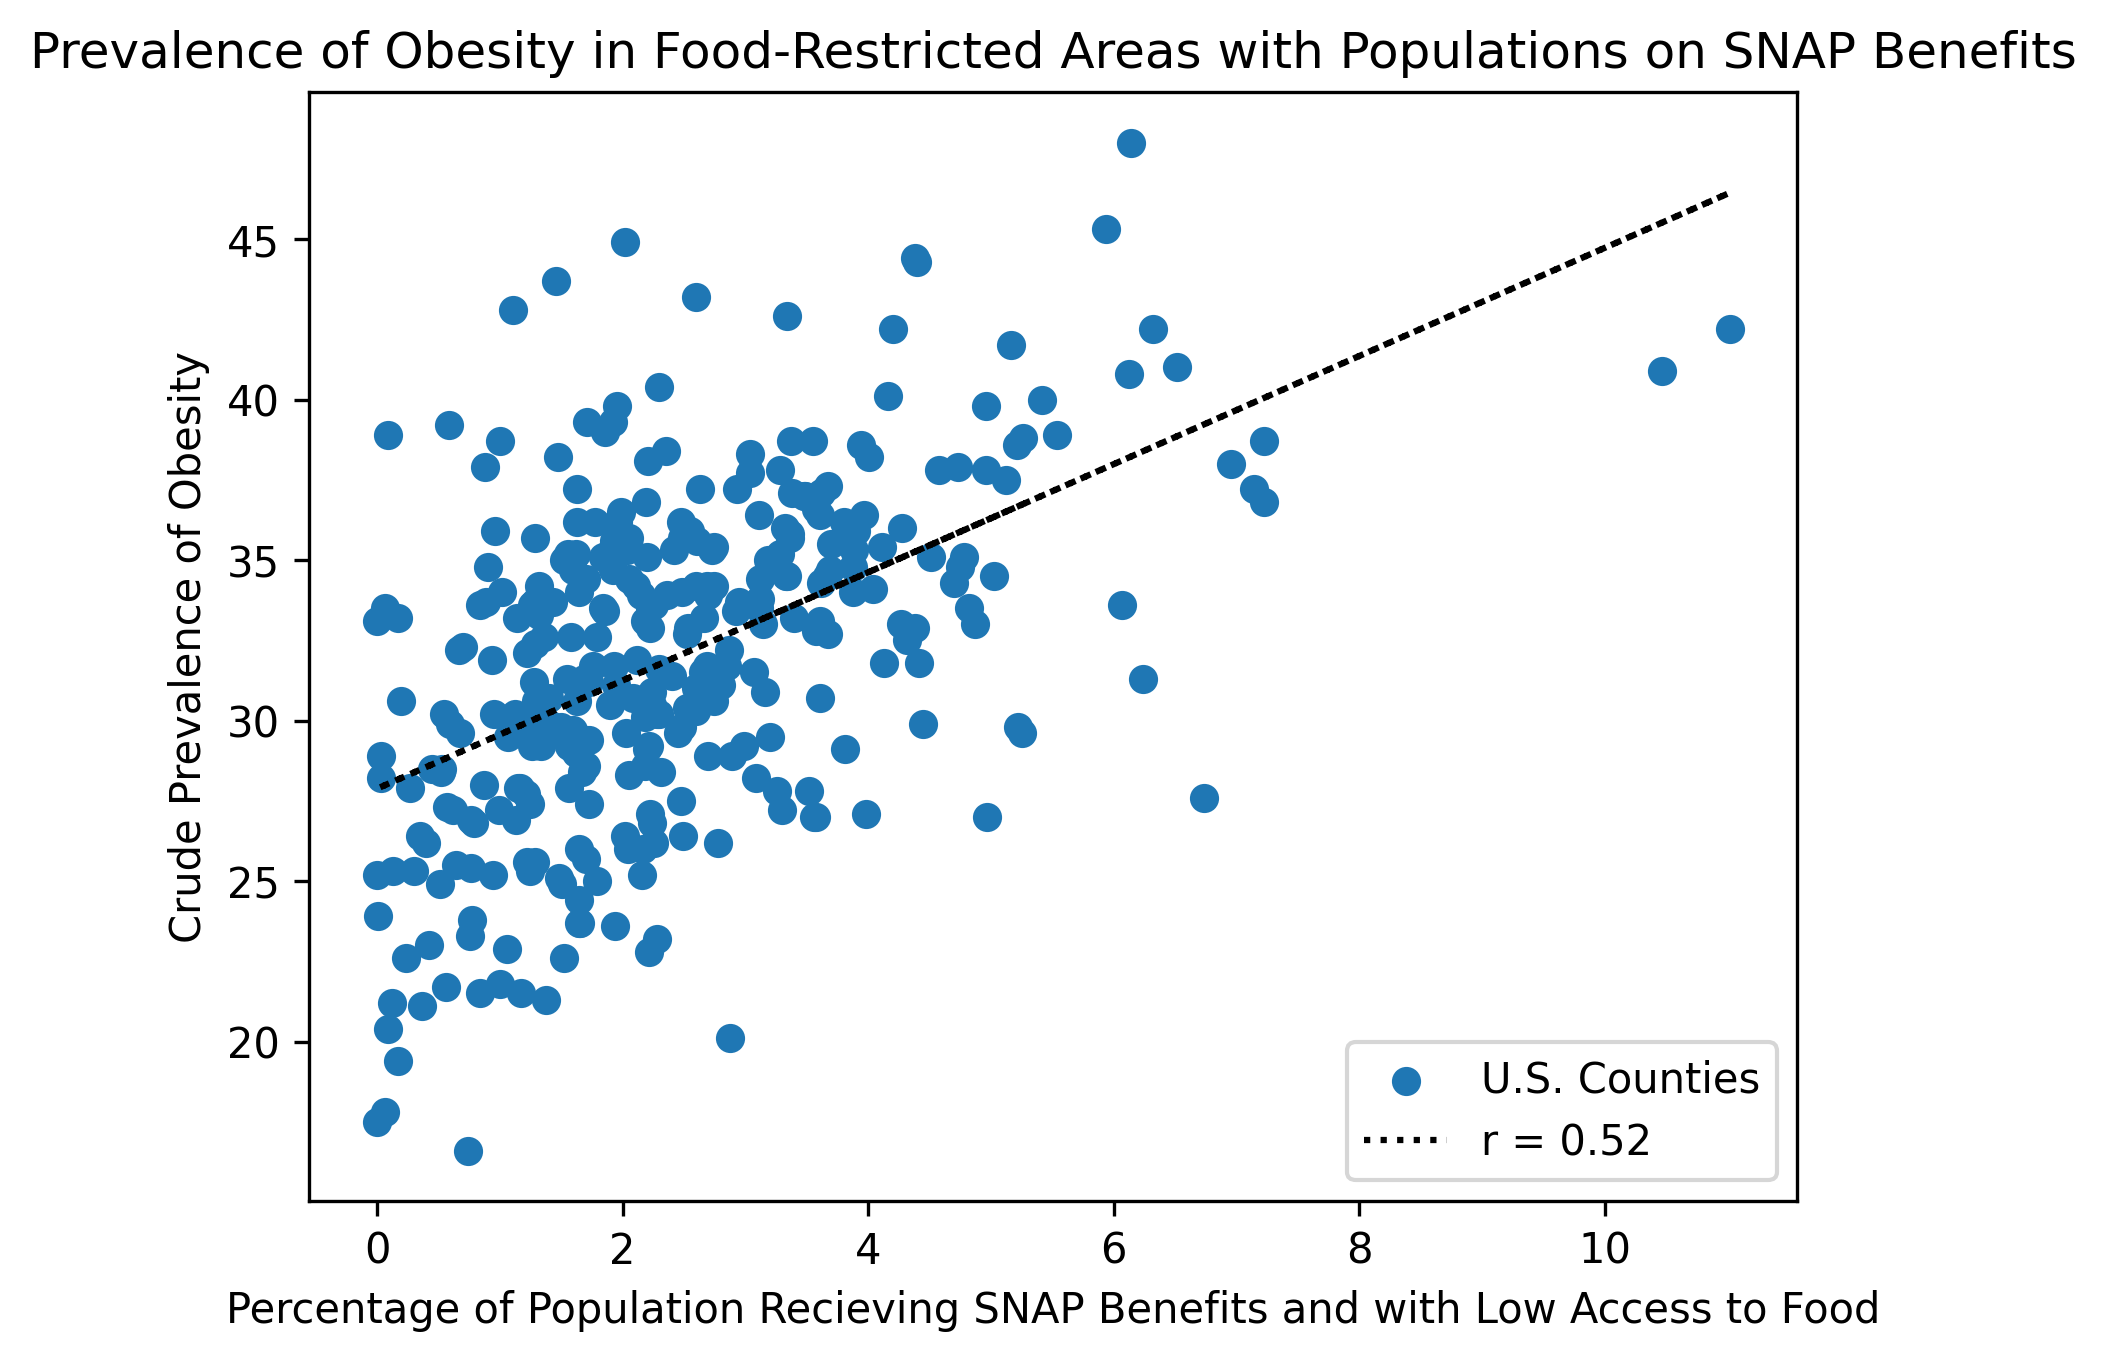

In [38]:
def plot_access_vs_disease(df, x_col, y_col, disease_name, show=False):
    fig, ax = plt.subplots(dpi=300)
    
    df_clean = df.dropna(subset=[x_col])
    
    x = df_clean[x_col]
    y = df_clean[y_col].dropna()
    
    if len(x) != len(y):
        raise ValueError("x and y data lengths do not match after dropping NaNs")
    
    ax.scatter(x, y, label='U.S. Counties')
    
    coefficients = np.polyfit(x, y, 1)
    trendline = np.poly1d(coefficients)
    
    pearson_corr, _ = pearsonr(x, y)
    label = f'r = {pearson_corr:.2f}'
    
    ax.plot(x, trendline(x), color='black', linestyle='dotted', label=label)
    ax.legend()
    
    ax.set_title(f"Prevalence of {disease_name} in Food-Restricted Areas with Populations on SNAP Benefits")
    ax.set_xlabel('Percentage of Population Recieving SNAP Benefits and with Low Access to Food')
    ax.set_ylabel(f'Crude Prevalence of {disease_name}')
    
    plt.savefig(f'{re.sub(r"\s+", "_", disease_name)}_access', bbox_inches='tight')
    
    if show:
        plt.show()
        
    plt.close()

    
plot_access_vs_disease(
    df3,
    x_col='PCT_LACCESS_SNAP15',
    y_col='OBESITY_CrudePrev_weighted_avg',
    disease_name='Obesity',
    show=True
)

In [ ]:
# I believe that this visualization clearly shows the relationship between food access and health. I chose obesity as the health
# proxy for a few reasons. First, it was the strongest correlation, making for the most convincing graph, but I also know that 
# obesity can open the door for a number of other health problems, something which the providers I am presenting to would be well-aware.
# Last, I want to establish this connection because I think that it is a bit counter-intuitive, that low access to good food could result
# in obesity, so I want to include this to drive home the way in which a "food desert" does not necessarily have no food: 
# it just not good food.

In [ ]:
# I'll include this in my presentation, and include a few similar charts for other health issues in the appendix. 

In [75]:
non_disease_columns = {
    'DENTAL_CrudePrev_weighted_avg', 
    'MAMMOUSE_CrudePrev_weighted_avg', 
    'LPA_CrudePrev_weighted_avg', 
    'PHLTH_CrudePrev_weighted_avg',
    'ACCESS2_CrudePrev_weighted_avg',
    'CHECKUP_CrudePrev_weighted_avg',
    'PAPTEST_CrudePrev_weighted_avg',
    'CHOLSCREEN_CrudePrev_weighted_avg',
    'COREM_CrudePrev_weighted_avg',
    'COREW_CrudePrev_weighted_avg',
    'COLON_SCREEN_CrudePrev_weighted_avg',
    'PCT_LACCESS_SNAP15'
}

disease_map = {
    'OBESITY_CrudePrev_weighted_avg': 'Obesity',
    'BPHIGH_CrudePrev_weighted_avg': 'High Blood Pressure',
    'DIABETES_CrudePrev_weighted_avg': 'Diabetes',
    'STROKE_CrudePrev_weighted_avg': 'Stroke',
    'KIDNEY_CrudePrev_weighted_avg': 'Kidney Disease',
    'CHD_CrudePrev_weighted_avg': 'Coronary Heart Disease',
    'COPD_CrudePrev_weighted_avg': 'Chronic Obstructive Pulmonary Disease',
    'CSMOKING_CrudePrev_weighted_avg': 'Smoking',
    'MHLTH_CrudePrev_weighted_avg': 'Mental Health',
    'TEETHLOST_CrudePrev_weighted_avg': 'Tooth Loss',
    'ARTHRITIS_CrudePrev_weighted_avg': 'Arthritis',
    'BPMED_CrudePrev_weighted_avg': 'Blood Pressure Medication',
    'HIGHCHOL_CrudePrev_weighted_avg': 'High Cholesterol',
    'SLEEP_CrudePrev_weighted_avg': 'Sleep Loss',
    'CASTHMA_CrudePrev_weighted_avg': 'Asthma',
    'CANCER_CrudePrev_weighted_avg': 'Cancer',
    'BINGE_CrudePrev_weighted_avg': 'Binge Drinking'
}

df4 = df3_correlations.drop(non_disease_columns).reset_index()
df4.columns = ['Variable', 'Correlation']

df4['Disease'] = df4['Variable'].map(disease_map)

plot_access_vs_disease(
    df3,
    x_col='PCT_LACCESS_SNAP15',
    y_col='BPHIGH_CrudePrev_weighted_avg',
    disease_name='High Blood Pressure'
)

                            Variable  Correlation  \
0     OBESITY_CrudePrev_weighted_avg     0.519407   
1      BPHIGH_CrudePrev_weighted_avg     0.453884   
2    DIABETES_CrudePrev_weighted_avg     0.446743   
3      STROKE_CrudePrev_weighted_avg     0.433447   
4      KIDNEY_CrudePrev_weighted_avg     0.415999   
5         CHD_CrudePrev_weighted_avg     0.402858   
6        COPD_CrudePrev_weighted_avg     0.396361   
7    CSMOKING_CrudePrev_weighted_avg     0.393036   
8       MHLTH_CrudePrev_weighted_avg     0.366704   
9   TEETHLOST_CrudePrev_weighted_avg     0.362084   
10  ARTHRITIS_CrudePrev_weighted_avg     0.327294   
11      BPMED_CrudePrev_weighted_avg     0.293288   
12   HIGHCHOL_CrudePrev_weighted_avg     0.268189   
13      SLEEP_CrudePrev_weighted_avg     0.238855   
14    CASTHMA_CrudePrev_weighted_avg     0.200808   
15     CANCER_CrudePrev_weighted_avg     0.072272   
16      BINGE_CrudePrev_weighted_avg    -0.331621   

                                  Disease  
0